In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from math import *
import sympy as sp
from typing import Union

plt.rcParams['figure.figsize'] = (10,7)

# 1. Simple Linear Regression

In [ ]:
def data_to_df(data : Union[str, list], point: Union[tuple, list] = None) -> pd.DataFrame :
    '''
    Transforms input data into a pandas dataframe.

    Parameters:
      data(str) : string describing a function, such as 'y = x + 2'.
      data(list): list of tuples (x,y) representing the data points
      data(list): list of lists, where each list contains all values of a variable.(IMPORTANT: first list must be variable Y values).

    Returns:
      result(pd.DataFrame): Pandas DataFrame of input data.
    '''

    if type(data) == str:
        equal_sign_pos = data.find('=')
        new_str = data[equal_sign_pos + 1:].lstrip()

        numbers = np.arange(1,10)
        y_values = []

        for x in numbers:
          y_values.append(eval(new_str))

        #Create DF:
        df = pd.DataFrame({'y': y_values, 'x': numbers})

    elif type(data) == list:

        if type(data[0]) == tuple:
            x_values = [pair[0] for pair in data]
            y_values = [pair[1] for pair in data]

            df = pd.DataFrame({'y': y_values, 'x': x_values})

        elif type(data) == list and all(isinstance(x, list) for x in data) and len(data) >= 3 and len({len(i) for i in data}) == 1:

            data = np.array(data)
            _, inds = sp.Matrix(data).T.rref()   # to check the rows you need to transpose!
            data = data.take(inds, axis=0)
            name_columns = ['y']
            for i in range(1, len(data)):
                name_columns.append(f'x{i}')
            data = np.array(data).T

            df = pd.DataFrame(data, columns = name_columns)

        elif type(data) == list and all(isinstance(x, list) for x in data) and len(data) == 2 and len({len(i) for i in data}) == 1:
          y = data[0]
          x = data[1]
          df = pd.DataFrame({'y': y, 'x': x})



    if point != None:

       assert len(point) == df.shape[1] - 1

       if (len(data) < 3 or type(data) == str):

         df.drop((df [(df['x'] == point[0])]).index, inplace=True)
         df.at[-1, 1:] = point
         df.sort_values(by=['x'], inplace = True)  #sort dataframe to avoid visualization problems


       else:

         points_array = df.iloc[:, 1:].to_numpy()
         points_list = points_array.tolist()
         df['points'] = points_list
         positions_to_remove = []

         for i in range(len(df['points'])):
           if df['points'][i] == point:
             positions_to_remove.append(i)

         df.drop(positions_to_remove, axis = 0, inplace = True )
         df.at[-1, 1: -1] = point
         df.sort_values(by=['x1'], inplace = True)  #sort dataframe to avoid visualization problems
         df.drop(['points'], axis = 1, inplace = True)
       df.reset_index(inplace = True, drop = True) #avoid surjectivity


    return df

In [ ]:
def r_squared_and_RMSD(data : pd.DataFrame) -> pd.DataFrame :
    '''
    Obtains Coefficient of Determination (r^2) and root-mean-square deviation
    (RMSD) of given Pandas DataFrame from "y" and "prediction" columns.

    Parameters:
      data(pd.DataFrame) : A Pandas DataFrame.

    Returns:
      result(pd.DataFrame): Pandas DataFrame of inputted DataFrame with new "R_squared" and "RMSD" columns.
    '''
    #CALCULATE R_SQUARED WITH NUMPY AND ADD IT TO DATAFRAME
    actual = data['y']
    predict = data['prediction']
    ssr = ((actual - predict) ** 2).sum()
    sst = ((actual - np.mean(actual)) ** 2).sum()
    R_sq = 1 - (ssr / sst)
    data['R_squared'] = '--'
    data.at[0,'R_squared'] = R_sq

    #CALCULATE
    N = data.shape[0]
    RMSD = math.sqrt( ((data['y'] - data['prediction'])**2).sum() / N)

    data['RMSD'] = '--'
    data.at[0,'RMSD'] = RMSD

    return data

In [ ]:
def simple_linear_regression(data : list, point: Union[tuple, list] = None) -> pd.DataFrame:
    '''
    Fits a linear equation to observed data following the least squares method, obtaining  y = m * x + n  as final result.

    Parameters:
      data(str) : string describing a function, such as 'y = x + 2'.
      data(list): list of tuples (x,y) representing the data points
      data(list): list of lists, where each list contains all values of a variable.(IMPORTANT: first list must be variable Y values).

    Returns:
      result(pd.DataFrame): Pandas DataFrame of inputted data with new "prediction" column, among others.
    '''

    df = data_to_df(data, point)

    df['x * y'] = df['x'] * df['y']
    df['x**2'] = (df['x']) ** 2

    new_df = df.copy().dropna()  #create new dataframe in case user inserts point so nan values dont affect internal operations.

    ones_array = np.ones_like(new_df['y'])
    new_df.insert(loc = 2, column = 'ones', value = ones_array)
    matrix = np.array(new_df.iloc[:, 1:3].dropna())
    # Beta = (Xt * X)**-1 * Xt*Y   where Xt is the transposed matrix
    Xt = matrix.T
    beta = np.matmul(np.linalg.inv(np.matmul(Xt, matrix)), np.matmul(Xt, new_df['y'])) #coefficients
    m, n = (beta[0], beta[1])

    if n >= 0 :
        equation = f'LINEAL: y = {round(m,3)} * x + {round(n,3)}'
    else:
        equation = f'LINEAL: y = {round(m,3)} * x - {abs(round(n,3))}'

    df['prediction'] = df['x'] * m + n
    x = df['x']
    y = df['y']
    prediction = df['prediction']
    r_squared_and_RMSD(df)

    #VISUALIZATION
    plt.rcParams['text.color'] = 'blue'
    plt.scatter(x, y)
    plt.plot(x, prediction, color = 'red')
    plt.title(equation)

    if point != None:
      point_x = point[0]
      point_prediction = round(df.loc[(df['x'] == point_x) , 'prediction'].item(), 5)

      print(f'Predicted value for point {point} is {point_prediction}')

      plt.plot(point_x, point_prediction, 'g*', color = 'yellow', markersize = 10, label = 'Predicted Point' )
      plt.legend(loc="upper left")

    plt.show()

    return df

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


Predicted value for point [1] is 1.66


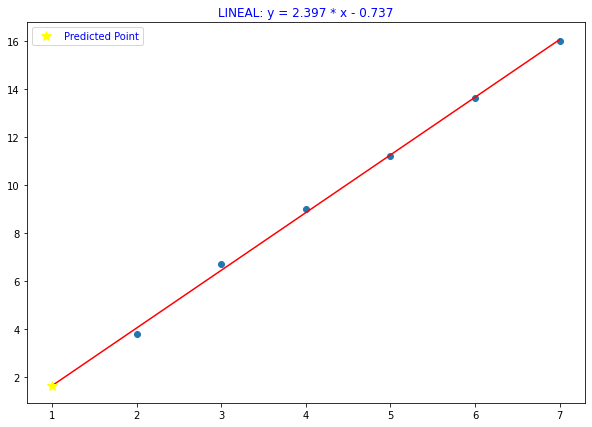

,y,x,x * y,x**2,prediction,R_squared,RMSD
0,NaN,1.0,NaN,1.0,1.660000,0.998462,0.148736
1,3.8,2.0,7.6,4.0,4.057143,--,--
2,6.7,3.0,20.1,9.0,6.454286,--,--
3,9.0,4.0,36.0,16.0,8.851429,--,--
4,11.2,5.0,56.0,25.0,11.248571,--,--
5,13.6,6.0,81.6,36.0,13.645714,--,--
6,16.0,7.0,112.0,49.0,16.042857,--,--


In [ ]:
simple_linear_regression([[1.5, 3.8, 6.7, 9.0, 11.2, 13.6, 16], [1, 2, 3, 4, 5, 6, 7]], point = [1])

# 2. Multiple Linear Regression

MATERIAL:

Youtube video = https://www.youtube.com/watch?v=s_p3pdmyX8s

Math Document = https://drive.google.com/file/d/1EFN098sCvty9vOoBnGYBJ57cwJhC6j9p/view?usp=sharing

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
#Set up up figure size and DPI for screen demo
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['figure.dpi'] = 70

In [ ]:
def multiple_linear_regression(data : list,  point: Union[tuple, list] = None) -> pd.DataFrame:
    '''
    Model that estimates the relationship between a quantitative dependent
    variable and two or more independent variables using a straight line.
    Follows the matrix approach, using the formula defined in the beta variable.
    If using Jupyter Notebook, please write "%matplotlib notebook" in the same cell
    when executing for a better representation.

    Parameters:
      data(list): list of lists, where first list contains all values of the dependant variable (Y), and
      the remaining lists contain values of the independent variables (x1, x2 ...).
      All listS must have same length and must be INDEPENDENT (a list can not be obtained from the product of another list with a number).

    Returns:
      result(pd.DataFrame): Pandas DataFrame of inputted data with new "prediction" column, among others.
    '''

    initial_df = data_to_df(data, point)
    df = initial_df.copy()

    ones_array = np.ones_like(df['y'])
    df.insert(loc = 1, column = 'ones', value = ones_array)

    new_df = df.copy().dropna()  #create new dataframe in case user inserts point so nan values dont affect internal operations.
    matrix = np.array(new_df.iloc[:, 1:])

    # Beta = (Xt * X)**-1 * Xt*Y     where Xt is the transposed matrix

    Xt = matrix.T
    beta = np.matmul(np.linalg.inv(np.matmul(Xt, matrix)), np.matmul(Xt, new_df['y'])) #coefficients

    df['prediction'] = (beta * df.iloc[:, 1:]).sum(axis = 1)
    plane_variables = ['x', 'y', 'z', 't', 's']

    plane = 'MULTIPLE: '
    plane += str(round(beta[0], 3)) + plane_variables[0]
    for i in range(1, len(beta)):
        aprox_beta = round(beta[i], 3)

        if aprox_beta >= 0:
            plane += ' + ' + str(aprox_beta) + plane_variables[i]
        else:
            plane += ' - ' + str(abs(aprox_beta)) + plane_variables[i]

    r_squared_and_RMSD(df)

    #3D Axes
    if initial_df.shape[1] == 3:  #only plot if there are 3 variables (3D)
        x1 = df['x1']
        x2 = df['x2']
        y = df['y']

        #GENERATE PLANE

        max_value_prediction = int(df['prediction'].max()) * 2

        x1_s = np.tile(np.arange(max_value_prediction), (max_value_prediction,1))
        x2_s = np.tile(np.arange(max_value_prediction), (max_value_prediction,1)).T
        beta_0, beta_1, beta_2 = beta
        z = beta_0 + beta_1 * x1_s + beta_2 * x2_s

        fig = plt.figure()
        ax = fig.add_subplot(111, projection = '3d')
        ax.scatter(x1, x2, y, color = 'red')
        ax.plot_surface(x1_s, x2_s, z , alpha=0.2)
        ax.set_title(plane)
        ax.view_init(40, -70)
        plt.show()

    if point != None:
      point_prediction = round(df.loc[(df['y'].isnull()) , 'prediction'].item(), 5)
      print(f'Predicted value for point {point} is {point_prediction}')
      print()

    return df

In [ ]:
#third list is a linear combination of the second list, ERROR.
multiple_linear_regression([ [9, 10, 13, 14, 16], [1, 3, 4, 6, 7], [10, 30, 40, 60, 70] ])

,y,ones,x1,prediction,R_squared,RMSD
0,9,1,1,8.666667,0.934739,0.658281
1,10,1,3,11.000000,--,--
2,13,1,4,12.166667,--,--
3,14,1,6,14.500000,--,--
4,16,1,7,15.666667,--,--


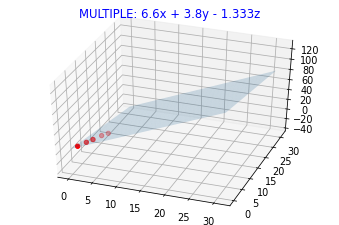

,y,ones,x1,x2,prediction,R_squared,RMSD
0,9,1,1,1,9.066667,0.991968,0.23094
1,10,1,2,3,10.200000,--,--
2,13,1,3,4,12.666667,--,--
3,14,1,4,6,13.800000,--,--
4,16,1,5,7,16.266667,--,--


In [ ]:
multiple_linear_regression([[9, 10, 13, 14, 16],[1,2,3,4,5], [1, 3, 4, 6, 7], [10, 30, 40, 60, 70]])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


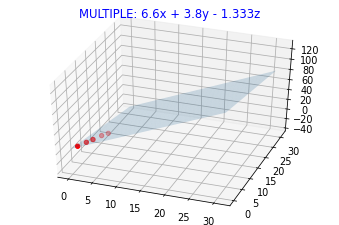

Predicted value for point [1, 2] is 7.73333



,y,ones,x1,x2,prediction,R_squared,RMSD
0,9.0,1.0,1.0,1.0,9.066667,0.991968,0.210819
1,NaN,1.0,1.0,2.0,7.733333,--,--
2,10.0,1.0,2.0,3.0,10.200000,--,--
3,13.0,1.0,3.0,4.0,12.666667,--,--
4,14.0,1.0,4.0,6.0,13.800000,--,--
5,16.0,1.0,5.0,7.0,16.266667,--,--


In [ ]:
multiple_linear_regression([[9, 10, 13, 14, 16],[1,2,3,4,5], [1, 3, 4, 6, 7], [10, 30, 40, 60, 70]], [1,2])

# 3. Nonlinear Regression

## 3.1 Exponential Regression

In [ ]:
def non_linear_exponential_regression(data : Union[str, list], point: Union[tuple, list] = None) -> pd.DataFrame :
    '''
    This function finds the equation of the exponential function that fits best for a set of data.
    As a result, we get an equation of the form y = a * e ^ (bx) where a ≠ 0

    Parameters:
      data(str) : string describing a function, such as 'y = x + 2'.
      data(list): list of tuples (x,y) representing the data points
      data(list): list of lists, where each list contains all values of a variable.(IMPORTANT: first list must be variable Y values).

    Returns:
      result(pd.DataFrame): Pandas DataFrame of inputted data with new "prediction" column, among others.
    '''

    df = data_to_df(data, point)
    df['z = ln(y)'] = np.log(df['y'])
    df['xz'] = df['x'] * df['z = ln(y)']
    df['x^2'] = df['x'] ** 2

    n = df.shape[0]
    a1 = (n * df['xz'].sum() - df['x'].sum() * df['z = ln(y)'].sum()) / \
    (n * df['x^2'].sum() - (df['x'].sum())**2 )

    a0 = (df['z = ln(y)'].sum() / n) - a1 * (df['x'].sum() / n)

    A = math.e ** a0
    b = a1

    df['prediction'] = A * math.e ** (b * df['x'])
    r_squared_and_RMSD(df)

    equation = f'EXPONENTIAL: y = {round(A,5)} * {round(math.e, 3)} ^ ({round(b,3)}x)'


    x = df['x']
    y = df['y']
    prediction = df['prediction']
    #VISUALIZATION
    plt.rcParams['text.color'] = 'blue'
    plt.scatter(x, y)
    plt.plot(x, prediction, color = 'red')
    plt.title(equation)

    if point != None:
      point_x = point[0]
      point_prediction = round(df.loc[(df['x'] == point_x) , 'prediction'].item(), 5)

      print(f'Predicted value for point {point} is {point_prediction}')

      plt.plot(point_x, point_prediction, 'g*', color = 'yellow', markersize = 10, label = 'Predicted Point' )
      plt.legend(loc="upper left")

    plt.show()

    return df

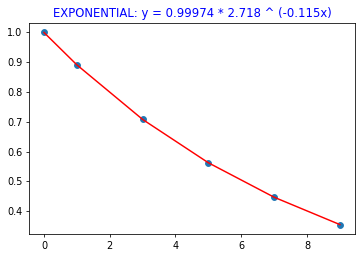

,y,x,z = ln(y),xz,x^2,prediction,R_squared,RMSD
0,1.000,0,0.000000,0.000000,0,0.999739,0.999999,0.00022
1,0.891,1,-0.115411,-0.115411,1,0.891089,--,--
2,0.708,3,-0.345311,-1.035934,9,0.707930,--,--
3,0.562,5,-0.576253,-2.881267,25,0.562418,--,--
4,0.447,7,-0.805197,-5.636377,49,0.446816,--,--
5,0.355,9,-1.035637,-9.320737,81,0.354975,--,--


In [ ]:
non_linear_exponential_regression([[1.000, 0.891, 0.708, 0.562, 0.447, 0.355], [0, 1, 3, 5, 7, 9]])

Predicted value for point [1] is 0.92584


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


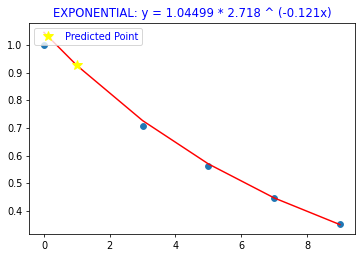

,y,x,z = ln(y),xz,x^2,prediction,R_squared,RMSD
0,1.000,0.0,0.000000,0.000000,0.0,1.044988,0.990371,0.02025
1,NaN,1.0,NaN,NaN,1.0,0.925842,--,--
2,0.708,3.0,-0.345311,-1.035934,9.0,0.726755,--,--
3,0.562,5.0,-0.576253,-2.881267,25.0,0.570478,--,--
4,0.447,7.0,-0.805197,-5.636377,49.0,0.447806,--,--
5,0.355,9.0,-1.035637,-9.320737,81.0,0.351512,--,--


In [ ]:
non_linear_exponential_regression([[1.000, 0.891, 0.708, 0.562, 0.447, 0.355], [0, 1, 3, 5, 7, 9]], [1])

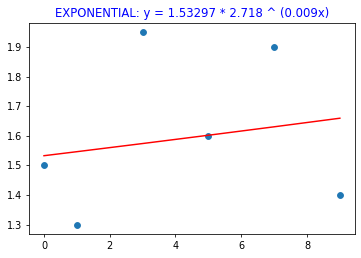

,y,x,z = ln(y),xz,x^2,prediction,R_squared,RMSD
0,1.50,0,0.405465,0.000000,0,1.532970,0.025327,0.239153
1,1.30,1,0.262364,0.262364,1,1.546566,--,--
2,1.95,3,0.667829,2.003488,9,1.574120,--,--
3,1.60,5,0.470004,2.350018,25,1.602166,--,--
4,1.90,7,0.641854,4.492977,49,1.630711,--,--
5,1.40,9,0.336472,3.028250,81,1.659764,--,--


In [ ]:
non_linear_exponential_regression([[1.5, 1.3, 1.95, 1.6, 1.9, 1.4], [0, 1, 3, 5, 7, 9]])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


Predicted value for point [1] is 1.41774


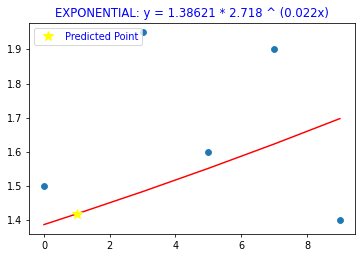

,y,x,z = ln(y),xz,x^2,prediction,R_squared,RMSD
0,1.50,0.0,0.405465,0.000000,0.0,1.386211,-0.675473,0.257799
1,NaN,1.0,NaN,NaN,1.0,1.417736,--,--
2,1.95,3.0,0.667829,2.003488,9.0,1.482954,--,--
3,1.60,5.0,0.470004,2.350018,25.0,1.551171,--,--
4,1.90,7.0,0.641854,4.492977,49.0,1.622526,--,--
5,1.40,9.0,0.336472,3.028250,81.0,1.697164,--,--


In [ ]:
non_linear_exponential_regression([[1.5, 1.3, 1.95, 1.6, 1.9, 1.4], [0, 1, 3, 5, 7, 9]], [1])

## 3.2 Logarithmic Regression

In [ ]:
def non_linear_logarithmic_regression(data : Union[str, list], point: Union[tuple, list] = None) -> pd.DataFrame :
    '''
    Returns logarithmic regression of the data, getting as a result the curve y = a*ln(x) + b.

    Parameters:
      data(str) : string describing a function, such as 'y = x + 2'.
      data(list): list of tuples (x,y) representing the data points
      data(list): list of lists, where each list contains all values of a variable.(IMPORTANT: first list must be variable Y values).

    Returns:
      result(pd.DataFrame): Pandas DataFrame of inputted data with new "prediction" column, among others.
    '''

    np.seterr(divide = 'ignore')
    df = data_to_df(data, point)

    df["x' = lnX"] = np.log(df['x'])
    df["x'y"] = df["x' = lnX"] * df['y']
    df["x'^2"] = df["x' = lnX"] ** 2

    # Remove data points with x greater than 1 since ln cant take values lower than 0and ln(1) = 0, and we must avoid dividing by this value.
    df = df[df['x'] > 1].reset_index(drop=True)
    n = df.shape[0]

    b = ( n * df["x'y"].sum() - df["x' = lnX"].sum() * df['y'].sum() ) /\
    (n * df["x'^2"].sum() - (df["x' = lnX"].sum())**2 )

    a = (df['y'].sum() / n) - b * (df["x' = lnX"].sum() / n)
    df['prediction'] = a + b * df["x' = lnX"]

    if b >= 0 :
        equation = f'LOGARITHMIC: y = {round(a,3)} * ln(x) + {round(b,3)}'
    else:
        equation = f'LOGARITHMIC: y = {round(a,3)} * ln(x) - {abs(round(b,3))}'

    r_squared_and_RMSD(df)

    x = df['x']
    y = df['y']
    prediction = df['prediction']
    #VISUALIZATION
    plt.rcParams['text.color'] = 'blue'
    plt.scatter(x, y)
    plt.plot(x, prediction, color = 'red')
    plt.title(equation)

    if point != None:
      point_x = point[0]
      point_prediction = round(df.loc[(df['x'] == point_x) , 'prediction'].item(), 5)

      print(f'Predicted value for point {point} is {point_prediction}')

      plt.plot(point_x, point_prediction, 'g*', color = 'yellow', markersize = 10, label = 'Predicted Point' )
      plt.legend(loc="upper left")

    plt.show()

    return df

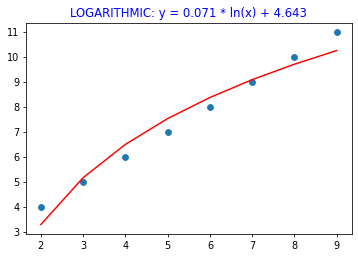

,y,x,x' = lnX,x'y,x'^2,prediction,R_squared,RMSD
0,4,2,0.693147,2.772589,0.480453,3.288737,0.955826,0.481575
1,5,3,1.098612,5.493061,1.206949,5.171170,--,--
2,6,4,1.386294,8.317766,1.921812,6.506778,--,--
3,7,5,1.609438,11.266065,2.590290,7.542756,--,--
4,8,6,1.791759,14.334076,3.210402,8.389212,--,--
5,9,7,1.945910,17.513191,3.786566,9.104880,--,--
6,10,8,2.079442,20.794415,4.324077,9.724820,--,--
7,11,9,2.197225,24.169470,4.827796,10.271646,--,--


In [ ]:
a = 'y = x + 2'
non_linear_logarithmic_regression(a)

Predicted value for point [2] is 1.02165


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


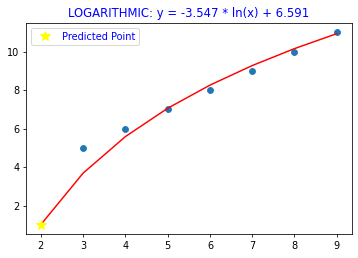

,y,x,x' = lnX,x'y,x'^2,prediction,R_squared,RMSD
0,NaN,2.0,0.693147,NaN,0.480453,1.021655,0.926675,0.506594
1,5.0,3.0,1.098612,5.493061,1.206949,3.693974,--,--
2,6.0,4.0,1.386294,8.317766,1.921812,5.590014,--,--
3,7.0,5.0,1.609438,11.266065,2.590290,7.060697,--,--
4,8.0,6.0,1.791759,14.334076,3.210402,8.262333,--,--
5,9.0,7.0,1.945910,17.513191,3.786566,9.278302,--,--
6,10.0,8.0,2.079442,20.794415,4.324077,10.158374,--,--
7,11.0,9.0,2.197225,24.169470,4.827796,10.934652,--,--


In [ ]:
non_linear_logarithmic_regression(a, [2])

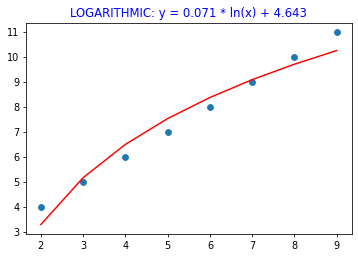

,y,x,x' = lnX,x'y,x'^2,prediction,R_squared,RMSD
0,4,2,0.693147,2.772589,0.480453,3.288737,0.955826,0.481575
1,5,3,1.098612,5.493061,1.206949,5.171170,--,--
2,6,4,1.386294,8.317766,1.921812,6.506778,--,--
3,7,5,1.609438,11.266065,2.590290,7.542756,--,--
4,8,6,1.791759,14.334076,3.210402,8.389212,--,--
5,9,7,1.945910,17.513191,3.786566,9.104880,--,--
6,10,8,2.079442,20.794415,4.324077,9.724820,--,--
7,11,9,2.197225,24.169470,4.827796,10.271646,--,--


In [ ]:
a = 'y = x + 2'
non_linear_logarithmic_regression(a)

Predicted value for point [5] is 158.57741


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


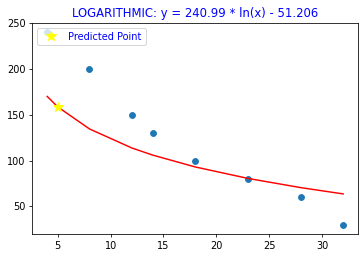

,y,x,x' = lnX,x'y,x'^2,prediction,R_squared,RMSD
0,240.0,4.0,1.386294,332.710647,1.921812,170.003687,0.65055,37.067734
1,NaN,5.0,1.609438,NaN,2.590290,158.577407,--,--
2,200.0,8.0,2.079442,415.888308,4.324077,134.510418,--,--
3,150.0,12.0,2.484907,372.735997,6.174761,113.748187,--,--
4,130.0,14.0,2.639057,343.077453,6.964624,105.854753,--,--
5,100.0,18.0,2.890372,289.037176,8.354249,92.985956,--,--
6,80.0,23.0,3.135494,250.839537,9.831324,80.434225,--,--
7,60.0,28.0,3.332205,199.932271,11.103587,70.361485,--,--
8,30.0,32.0,3.465736,103.972077,12.011325,63.523881,--,--


In [ ]:
non_linear_logarithmic_regression([[240, 200, 150, 130, 100, 80, 60, 30], [4, 8, 12, 14, 18, 23, 28, 32]], [5])

## 3.3 Polynomial Regression

In [ ]:
def non_linear_polynomial_regression(data : Union[str, list] , polynomial_degree : int, point: Union[tuple, list] = None) -> pd.DataFrame:
    '''
    Returns the polynomial regression of the input data and the given degree.

    Parameters:
      data(str) : string describing a function, such as 'y = x + 2'.
      data(list): list of tuples (x,y) representing the data points
      data(list): list of lists, where each list contains all values of a variable.(IMPORTANT: first list must be variable Y values).
      polynomial_degree(int) : integer representing the desired degree of polynomial regression equation.

    Returns:
      result(pd.DataFrame): Pandas DataFrame of inputted data with new "prediction" column, among others.
    '''
    if polynomial_degree == 1:   #a polynomial regression equation of degree 1 is equal to a linear regression equation
        return simple_linear_regression(data)

    else:

        df = data_to_df(data, point)

        for i in range(polynomial_degree * 2 + 1):
            df['x^' + str(i)] = df['x']**i

        values_a = []
        for i in range(2 * polynomial_degree + 1):
            values_a.append(round(df['x^' + str(i)].sum(), 3))

        matrix = []
        for i in range(polynomial_degree + 1):
            matrix.append(values_a[i: i + polynomial_degree + 1 :])

        matrix_a = np.array(matrix)

        for e in range(1, polynomial_degree + 1):
            df['x^'+str(e)+' * y'] = df['x^'+str(e)] * df['y']

        values_b = [df['y'].sum()]
        for j in range(1, polynomial_degree + 1):
            values_b.append(round(df['x^'+str(j)+' * y'].sum(), 3))
        matrix_b = np.array(values_b)

        solution = np.linalg.solve(matrix_a, matrix_b)

        df['prediction'] =  (solution * df.iloc[:, 2: 3 + polynomial_degree]).sum(axis = 1)
        r_squared_and_RMSD(df)

        eq_variables = []
        for col in (df.iloc[:, 2: 3 + polynomial_degree]).columns:
            eq_variables.append(col)

        equation = 'POLYNOMIAL: '
        equation += str(round(solution[0], 3))
        for i in range(1, len(solution)):

            coeff = round(solution[i], 3)
            var = eq_variables[i]

            if coeff >= 0:
                equation += ' + ' + str(coeff) + var

            elif var == 'x^1':
                equation += ' + ' + str(coeff) + 'x'

            else:
                equation += ' - ' + str(abs(coeff)) + var

        plt.scatter(df['x'], df['y'], color = 'blue')
        plt.plot(df['x'], df['prediction'], color = 'red')
        plt.title(equation)


        x = df['x']
        y = df['y']
        prediction = df['prediction']
        #VISUALIZATION
        plt.rcParams['text.color'] = 'blue'
        plt.scatter(x, y)
        plt.plot(x, prediction, color = 'red')
        plt.title(equation)
        #plt.show()

        if point != None:
          point_x = point[0]
          point_prediction = round(df.loc[(df['x'] == point_x) , 'prediction'].item(), 5)

          print(f'Predicted value for point {point} is {point_prediction}')

          plt.plot(point_x, point_prediction, 'g*', color = 'yellow', markersize = 10, label = 'Predicted Point' )
          plt.legend(loc="upper left")

        plt.show()

        return df

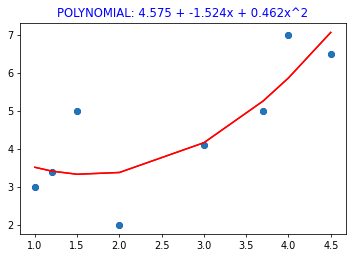

,y,x,x^0,x^1,x^2,x^3,x^4,x^1 * y,x^2 * y,prediction,R_squared,RMSD
0,3.0,1.0,1.0,1.0,1.00,1.000,1.0000,3.00,3.000,3.513354,0.678853,0.909812
1,3.4,1.2,1.0,1.2,1.44,1.728,2.0736,4.08,4.896,3.411854,--,--
2,5.0,1.5,1.0,1.5,2.25,3.375,5.0625,7.50,11.250,3.328916,--,--
3,2.0,2.0,1.0,2.0,4.00,8.000,16.0000,4.00,8.000,3.375517,--,--
4,4.1,3.0,1.0,3.0,9.00,27.000,81.0000,12.30,36.900,4.161833,--,--
5,5.0,3.7,1.0,3.7,13.69,50.653,187.4161,18.50,68.450,5.262126,--,--
6,7.0,4.0,1.0,4.0,16.00,64.000,256.0000,28.00,112.000,5.872303,--,--
7,6.5,4.5,1.0,4.5,20.25,91.125,410.0625,29.25,131.625,7.074096,--,--


In [ ]:
non_linear_polynomial_regression([[3, 3.4, 5, 2, 4.1, 5, 7, 6.5],[1, 1.2, 1.5, 2, 3, 3.7, 4, 4.5]], 2)

Predicted value for point [3] is 2.47828


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


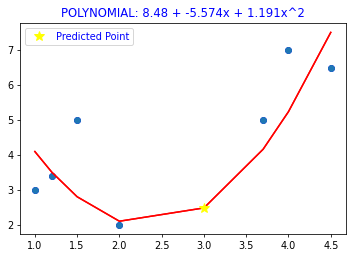

,y,x,x^0,x^1,x^2,x^3,x^4,x^1 * y,x^2 * y,prediction,R_squared,RMSD
0,3.0,1.0,1.0,1.0,1.00,1.000,1.0000,3.00,3.000,4.097245,0.466937,1.166956
1,3.4,1.2,1.0,1.2,1.44,1.728,2.0736,4.08,4.896,3.506562,--,--
2,5.0,1.5,1.0,1.5,2.25,3.375,5.0625,7.50,11.250,2.799199,--,--
3,2.0,2.0,1.0,2.0,4.00,8.000,16.0000,4.00,8.000,2.096690,--,--
4,NaN,3.0,1.0,3.0,9.00,27.000,81.0000,NaN,NaN,2.478284,--,--
5,5.0,3.7,1.0,3.7,13.69,50.653,187.4161,18.50,68.450,4.162781,--,--
6,7.0,4.0,1.0,4.0,16.00,64.000,256.0000,28.00,112.000,5.242030,--,--
7,6.5,4.5,1.0,4.5,20.25,91.125,410.0625,29.25,131.625,7.517209,--,--


In [ ]:
non_linear_polynomial_regression([[3, 3.4, 5, 2, 4.1, 5, 7, 6.5],[1, 1.2, 1.5, 2, 3, 3.7, 4, 4.5]], 2, [3])

In [ ]:
def best_regression_model(data : Union[str, list], point: Union[tuple, list] = None) -> pd.DataFrame :
    '''
    Returns best regression model by R-squared measurement.

    Parameters:
      data(str) : string describing a function, such as 'y = x + 2'.
      data(list): list of tuples (x,y) representing the data points
      data(list): list of lists, where each list contains all values of a variable.(IMPORTANT: first list must be variable Y values).

    Returns:
      result(pd.DataFrame): Pandas DataFrame of inputted data comparing every model by the coefficient of determination.
    '''
    models = ['simple_linear_regression', 'multiple_linear_regression', 'non_linear_exponential_regression', 'non_linear_logarithmic_regression', 'non_linear_polynomial_regression']
    r_sq = []

    if len(data) < 3 or type(data) == str:
        for model in models:
            if model not in ['multiple_linear_regression', 'non_linear_polynomial_regression']:
                r_sq.append(eval(model+'(data, point)').at[0,'R_squared'])

            elif model == 'multiple_linear_regression':
                r_sq.append(0)


            elif model == 'non_linear_polynomial_regression':
                #obtain best degree
                flag = 0
                rsq_polynomial = 0
                max_rsq = 0
                degree = 1

                while flag == 0:
                    rsq_polynomial = (eval(model+'(data, degree, point)').at[0,'R_squared'])

                    if rsq_polynomial > max_rsq:
                        max_rsq = rsq_polynomial
                        degree += 1
                        plt.cla()  #clear plot of non-optimal degrees
                    else:
                        flag = -1
                optimal_degree = degree - 1
                r_sq.append(max_rsq)
            #plt.show()
      #FIND BEST MODEL:
        sorted_rsq = sorted(r_sq, reverse=True)

        greatest_rsq = sorted_rsq[0]
        second_greatest = sorted_rsq[1]

        greatest_rsq_position = r_sq.index(greatest_rsq)
        sec_greatest_rsq_position =  r_sq.index(second_greatest)

        best_model = models[greatest_rsq_position]
        sec_best_model = models[sec_greatest_rsq_position]

        results = pd.DataFrame([r_sq], columns = ['simple', 'multiple', 'exponential', 'logarithmic', 'polynomial (degree = ' + str(optimal_degree) + ')'],
                              index = ['R_Squared'])

        if best_model == 'non_linear_polynomial_regression':
            response = f'Best model is {best_model}, with an optimal degree of {optimal_degree}.\nThe second best model is {sec_best_model}'

        else:
            response =  f'Best model is {best_model}'

        #plt.show()

        print()
        print(response)
        print()

        return(results)

    elif len(data) >= 3 and type(data) != str:

        print('Only Multiple Linear Regression can be applied')
        print()
        return (multiple_linear_regression(data))

Only Multiple Linear Regression can be applied



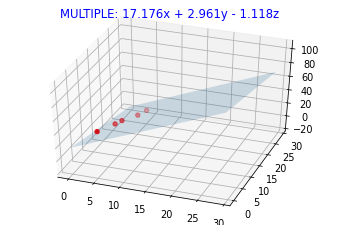

,y,ones,x1,x2,prediction,R_squared,RMSD
0,9,1,1,10,8.960784,0.951571,0.56707
1,10,1,3,14,10.411765,--,--
2,13,1,4,15,12.254902,--,--
3,14,1,6,18,14.823529,--,--
4,16,1,7,20,15.549020,--,--


In [ ]:
best_regression_model([[9, 10, 13, 14, 16], [1, 3, 4, 6, 7], [10, 14, 15, 18, 20]])

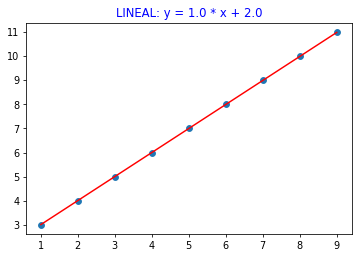

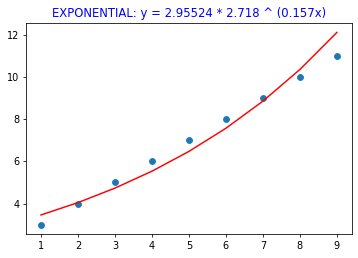

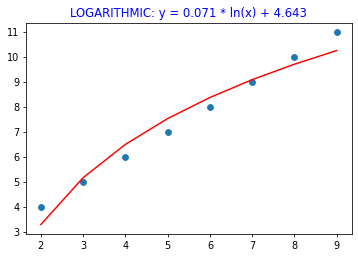

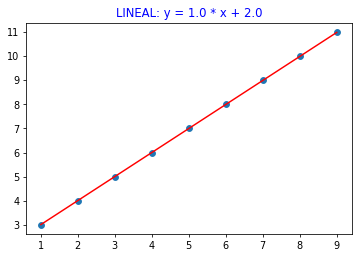

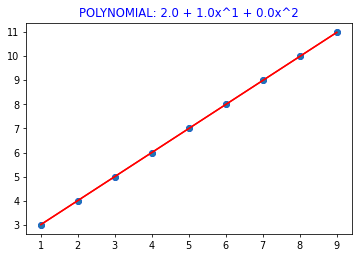


Best model is simple_linear_regression



,simple,multiple,exponential,logarithmic,polynomial (degree = 1)
R_Squared,1.0,0,0.960505,0.955826,1.0


In [ ]:
a = 'y = x + 2'
best_regression_model(a)

Predicted value for point [2] is 4.0


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


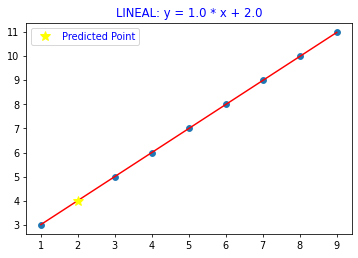

Predicted value for point [2] is 2.8158


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


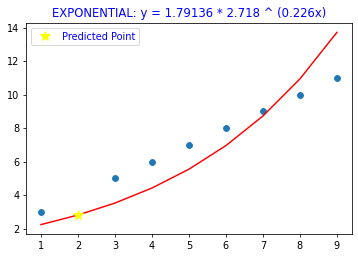

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


Predicted value for point [2] is 1.02165


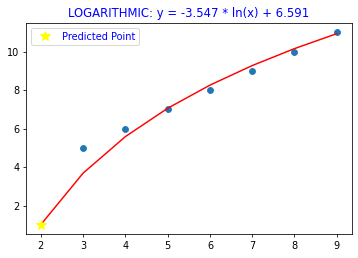

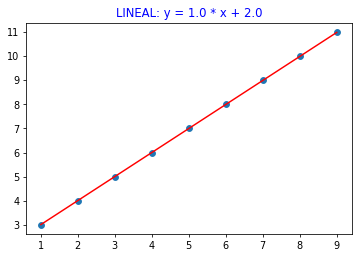

Predicted value for point [2] is 2.88485


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)


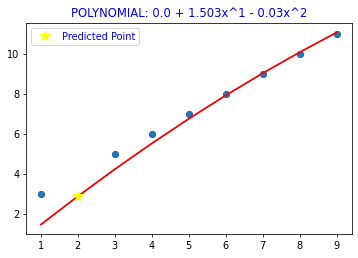


Best model is simple_linear_regression



,simple,multiple,exponential,logarithmic,polynomial (degree = 1)
R_Squared,1.0,0,0.665158,0.926675,1.0


In [ ]:
a = 'y = x + 2'
best_regression_model(a, [2])